In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz




In [329]:
df = pd.read_csv('NFWBS_PUF_2016_data.csv')
df_mapped = pd.read_csv('NFWBS_PUF_2016_data_mapped.csv')

with open('code_dict.json','r') as data_dict:
    dict = eval(data_dict.read()) 

In [330]:
df.head(3)

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
0,10350,2,3,5,5,6,55,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
1,7740,1,3,6,6,6,51,2,2,3,...,1,2,3,0,0,0,0,2,0,1.327561
2,13699,1,3,4,3,4,49,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156


In [331]:
df_mapped.head(3)

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
0,10350,Age 62+ oversample,200%+ FPL,5,5,6,55,Somewhat,Somewhat,Somewhat,...,Metro,West,Mountain,0,0,0,0,1,Less than 40% of county population below 200% ...,0.367292
1,7740,General population,200%+ FPL,6,6,6,51,Very little,Very little,Somewhat,...,Metro,Midwest,East-North Central,0,0,0,0,2,Less than 40% of county population below 200% ...,1.327561
2,13699,General population,200%+ FPL,4,3,4,49,Somewhat,Somewhat,Somewhat,...,Metro,West,Pacific,0,0,0,1+,2,40% or more of county population below 200% of...,0.835156


In [332]:
print(dict['PPMARIT'])

{1: 'Married', 2: 'Widowed', 3: 'Divorced/Separated', 4: 'Never married', 5: 'Living with partner'}


In [333]:
df_mapped['agecat'].value_counts()   #What age ranges are in this dataset

25-34    1116
45-54    1075
62-69    1021
35-44     828
75+       736
55-61     708
70-74     496
18-24     414
Name: agecat, dtype: int64

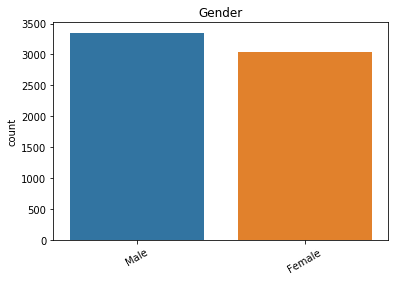

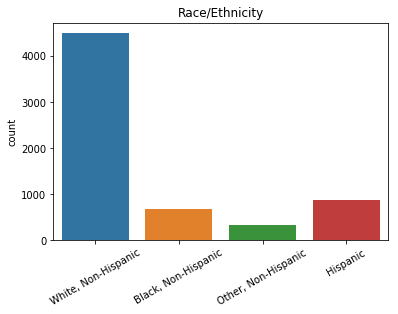

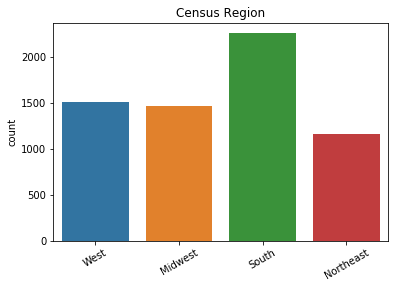

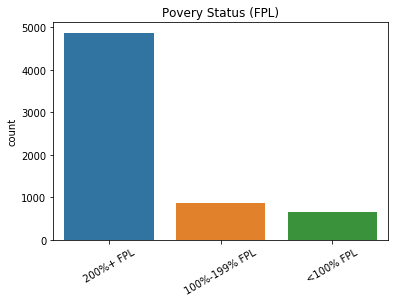

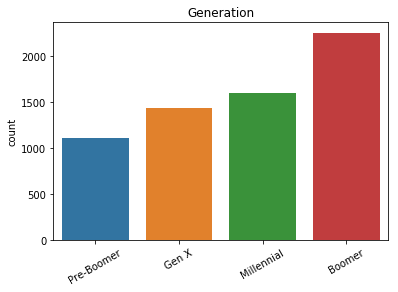

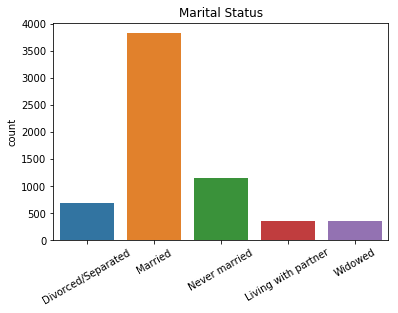

In [334]:
#Plotting some interesting variables

variable_dict = {"PPGENDER": "Gender", "PPETHM": "Race/Ethnicity", "PPREG4": "Census Region", "fpl":"Povery Status (FPL)", "generation":"Generation", "PPMARIT":"Marital Status"}

def createHistogram(dict):
    
    for key in dict:
        plt.figure()
        fig = sns.countplot(df_mapped[key])
        fig.set_title(dict[key])
        fig.set_xlabel('')
        plt.xticks(rotation=30)
        
        
createHistogram(variable_dict)        


In [335]:
#Lets look at some specific demographic cohorts

df_females = df_mapped.loc[df_mapped['PPGENDER'] == "Female"]
df_males = df_mapped.loc[df_mapped['PPGENDER'] == "Male"]

df_white = df_mapped.loc[df_mapped['PPETHM'] == "White, Non-Hispanic"]
df_black_or_hispanic = df_mapped.loc[(df_mapped['PPETHM'] == "Black, Non-Hispanic") | (df_mapped['PPETHM'] == "Hispanic")]

df_millenials = df_mapped.loc[df_mapped['generation'] == "Millennial"]
df_boomers = df_mapped.loc[df_mapped['generation'] == "Boomer"]

In [336]:
#Function for generating these plots
variable_dict_demographics = {"PPREG4": "Census Region", "PPMARIT":"Marital Status", "fpl":"Poverty Status (FPL)"}
def createHistogramDemographic(df_a, df_b, dict, legend_tuple):

    for variable in variable_dict_demographics.keys():
        
        df_1 = df_a[variable]
        df_2 = df_b[variable]
    
        plt.figure()
        ax = plt.hist([df_1, df_2], color = ['r', 'b'], histtype="barstacked")
        plt.legend(legend_tuple)
        variable_name = dict[variable]
        plt.title(dict[variable])
        plt.xticks(rotation=30)



/Users/Sarah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


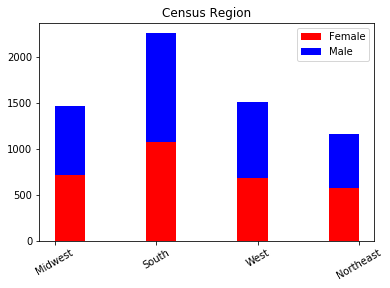

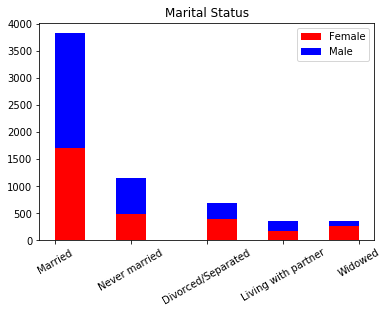

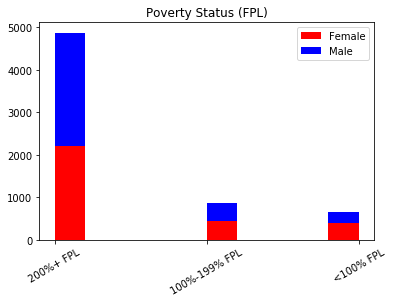

In [337]:


createHistogramDemographic(df_females, df_males, variable_dict_demographics, ("Female", "Male"))

/Users/Sarah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


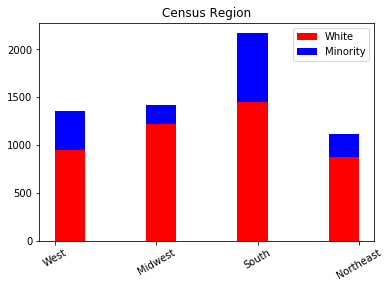

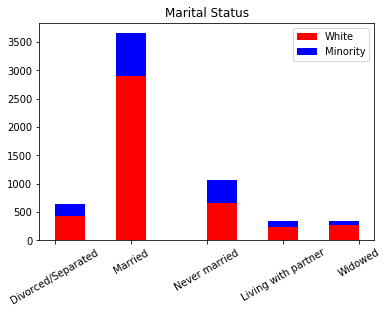

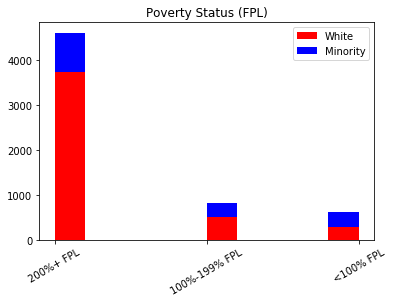

In [338]:
createHistogramDemographic(df_white, df_black_or_hispanic, variable_dict_demographics, ("White", "Minority"))

/Users/Sarah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


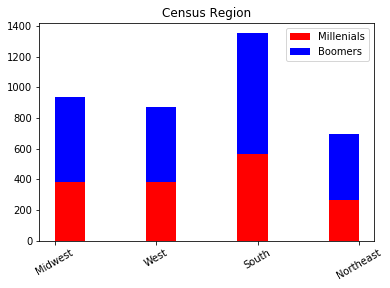

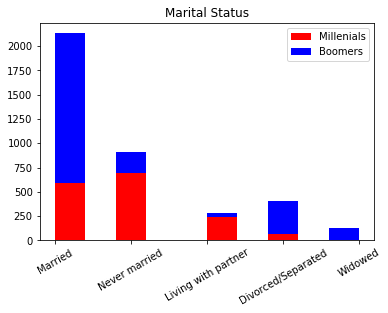

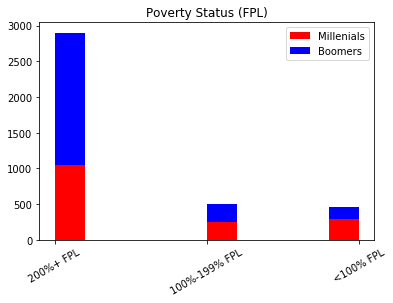

In [339]:
createHistogramDemographic(df_millenials, df_boomers, variable_dict_demographics, ("Millenials", "Boomers"))

In [340]:
#Preparing data for models
df = df.drop(['PUF_ID', 'sample', 'finalwt'], axis=1)
df = df.astype(str) 

df.head()

,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,FWB1_5,...,PPMARIT,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL
0,3,5,5,6,55,3,3,3,3,2,...,3,1,4,8,0,0,0,0,1,0
1,3,6,6,6,51,2,2,3,3,3,...,3,1,2,3,0,0,0,0,2,0
2,3,4,3,4,49,3,3,3,3,3,...,3,1,4,9,0,0,0,1,2,1
3,3,6,6,6,49,3,3,3,3,3,...,3,1,3,7,0,0,0,0,1,0
4,3,4,4,4,49,3,3,3,3,3,...,1,1,2,4,0,0,1,0,4,1


### K NEAREST NEIGHBORS

In [341]:
#We'll use FPL as our labels; we want the model to predict the FPL status of an individual given their survey responses
# specifically if an indvidual is <199% FPL
X_fpl = df.drop(["fpl"], axis=1)
y_fpl = df["fpl"]
y_fpl = y_fpl.str.replace("2", "1")
y_fpl = y_fpl.str.replace("3", "0")  #We'll mark individuals who are <199% FPL as "1"

#We'll use gender as our labels; we want the model to predict the gender of an individual given their survey responses
#specifically if the individual is female
X_gender = df.drop(["PPGENDER"], axis=1)
y_gender = df["PPGENDER"]  
y_gender = y_gender.str.replace("1", "0")
y_gender = y_gender.str.replace("2", "1") 


#Reminder for what those values actually mean using the data dictionary
print("Map for Gender Values: ", dict["PPGENDER"])
print("Map for FPL Values: ", dict["fpl"])


Map for Gender Values:  {1: 'Male', 2: 'Female'}
Map for FPL Values:  {1: '<100% FPL', 2: '100%-199% FPL', 3: '200%+ FPL'}


In [347]:
#Create and fit the model
#Even though the values are numbers, they are just categorical labels, so we'll change the datatype

def k_nearest_neighbors(X, y, target_name):
    print("\nPredicting individuals who are ", target_name, "...")
    X = pd.get_dummies(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5, stratify = y)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    print("Accuracy Score: ", accuracy_score(y_test, knn_pred))
    print()
    print(classification_report(y_test, knn_pred))


In [348]:
k_nearest_neighbors(X_fpl, y_fpl, "*** <199% of the Federal Poverty Line ***")  #For predicting individuals <199% FPL
k_nearest_neighbors(X_gender, y_gender, "*** Female ***")  #For predictin individuals who are female


Predicting individuals who are  *** <199% of the Federal Poverty Line *** ...
Accuracy Score:  0.8209538702111024

             precision    recall  f1-score   support

          0       0.84      0.94      0.89       975
          1       0.70      0.43      0.53       304

avg / total       0.81      0.82      0.80      1279


Predicting individuals who are  *** Female *** ...
Accuracy Score:  0.6293979671618452

             precision    recall  f1-score   support

          0       0.62      0.74      0.68       671
          1       0.64      0.51      0.57       608

avg / total       0.63      0.63      0.62      1279



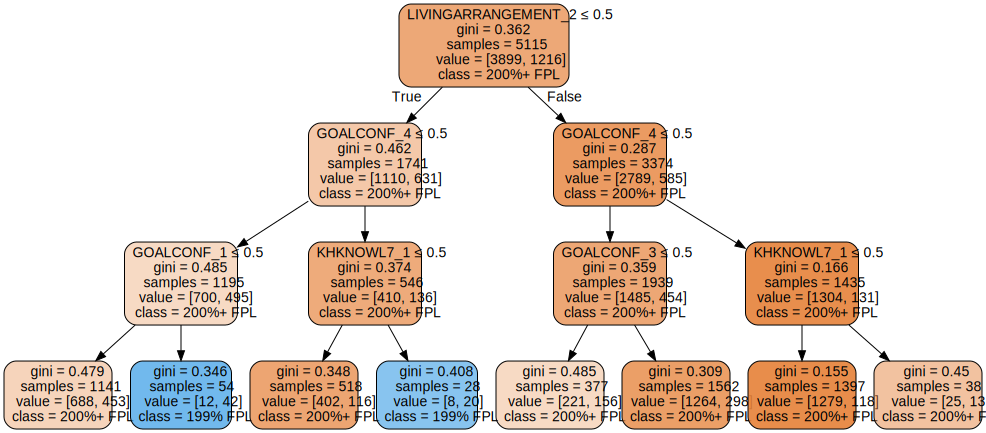

In [344]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

survey_categories = ["MATERIALISM_1", "SUBKNOWL1", "GOALCONF", "KHKNOWL7", "LIVINGARRANGEMENT", "fpl"]

#for cat in survey_categories:
    #print(dict[cat])
    #print()

df_tree = df[survey_categories]

X_tree = df_tree.drop(["fpl"], axis=1)
X_tree = pd.get_dummies(X_tree)
column_list = X_tree.columns.tolist()

y_tree = df_tree["fpl"]
y_tree = y_tree.str.replace("2", "1")
y_tree = y_tree.str.replace("3", "0")


#For predicting individuals <199% FPL   
    
X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size = 0.2, random_state = 5, stratify = y)
    
tree_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=5)
tree_clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                         feature_names=column_list,  
                         class_names=['200%+ FPL', '199% FPL'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph




In [345]:
y_tree.value_counts()  #The tree was not that accurate...

0    4874
1    1520
Name: fpl, dtype: int64